In [8]:
# Cell 1: Setup, Installation, and Data Loading (FIXED)

# 1. Install necessary libraries
!pip install pandas scikit-learn joblib xgboost streamlit pyngrok

# 2. Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Load the original raw data with the correct delimiter
try:
    df = pd.read_csv("hackathon_train_set.csv", delimiter=';')
except FileNotFoundError:
    print("File not found. Please ensure 'hackathon_train_set.csv' is uploaded.")
    raise

# CRITICAL FIX: Strip leading/trailing whitespace from all column names
df.columns = df.columns.str.strip()

print("Data loaded, columns cleaned, and libraries installed.")

Data loaded, columns cleaned, and libraries installed.


In [17]:
# Cell 2: Data Cleaning, Filtering, and Feature Engineering

# --- A. Data Cleaning and Initial Filtering ---

# Clean Price and Area: Remove formatting and convert to numeric
def clean_numeric(value):
    if isinstance(value, str):
        # We already stripped whitespace from column names in Cell 1
        return value.replace(' TL', '').replace('.', '').replace(',', '').strip()
    return value

# Apply cleaning now that the column name is correctly 'Price'
df['Price'] = df['Price'].apply(clean_numeric)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['m² (Gross)'] = pd.to_numeric(df['m² (Gross)'].apply(clean_numeric), errors='coerce')
df['m² (Net)'] = pd.to_numeric(df['m² (Net)'].apply(clean_numeric), errors='coerce')

# Drop rows with missing values in key features
df_processed = df.dropna(subset=['Price', 'm² (Gross)', 'm² (Net)'])


# --- B. MANDATORY HACKATHON FILTERING ---

# Filter: Keep only houses 'Available for Loan'
df_processed = df_processed[df_processed['Available for Loan'] == 'Yes'].drop(columns=['Available for Loan'])

# Drop noisy/redundant columns
cols_to_drop = ['Neighborhood', 'Adrtisement Date', 'Pick Up Data Time']
df_processed = df_processed.drop(columns=cols_to_drop, errors='ignore')


# --- C. FEATURE ENGINEERING FIX (Target/Ratio Encoding) ---

# Define key categorical columns
key_cols = ['District', 'Number of rooms', 'Building Age']

for col in key_cols:
    # 1. Calculate Mean Price for the group (Target Encoding)
    mean_price = df_processed.groupby(col)['Price'].transform('mean')
    df_processed[f'{col}_Avg_Price'] = mean_price

    # 2. Create a Price-to-Area Ratio for the group (Price Per Gross Square Meter for the category)
    df_processed[f'{col}_Avg_PPGSM'] = (mean_price / df_processed['m² (Gross)'])

print(f"Added {len(key_cols)*2} powerful aggregate numerical features.")


# --- D. Final Encoding and X/y Definition ---

# Identify remaining categorical columns (object columns)
categorical_cols = df_processed.select_dtypes(include='object').columns.tolist()

# One-Hot Encode all remaining categories
df_encoded = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

# Define Features (X) and Target (y)
target_col = 'Price'
X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col]

# Save the final feature columns list (THE BLUEPRINT)
feature_cols = X.columns.tolist()

print(f"Final Data shape after cleaning and encoding: {X.shape}")
print("Feature Engineering complete. Ready for modeling.")
# Add this line at the VERY END of your existing Cell 2 code
df_processed.to_csv('final_cleaned_data_for_submission.csv', index=False)

Added 6 powerful aggregate numerical features.
Final Data shape after cleaning and encoding: (24129, 346)
Feature Engineering complete. Ready for modeling.


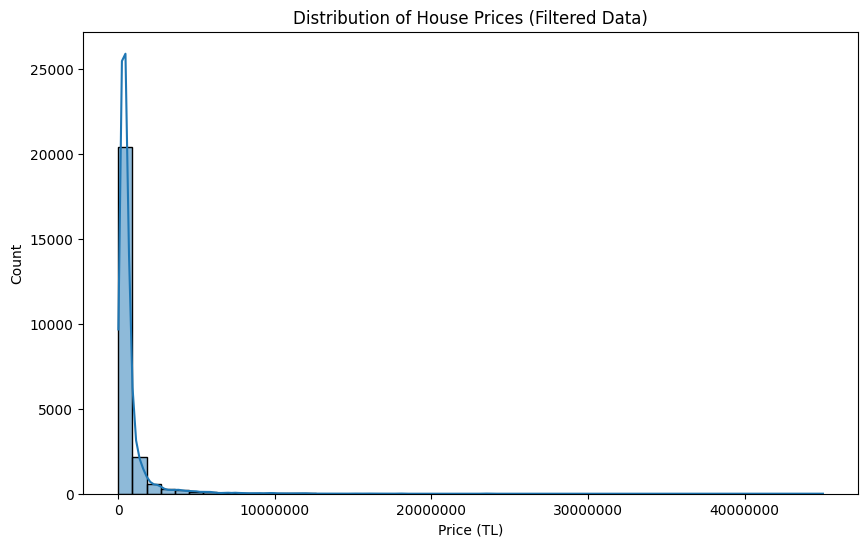

Price distribution plot saved as 'price_distribution.png'.


In [10]:
# Cell 3: Data Visualization and Diagnostics

# 1. Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_processed['Price'], bins=50, kde=True)
plt.title('Distribution of House Prices (Filtered Data)')
plt.xlabel('Price (TL)')
plt.ylabel('Count')
plt.ticklabel_format(style='plain', axis='x')
plt.savefig('price_distribution.png')
plt.show()

print("Price distribution plot saved as 'price_distribution.png'.")

In [11]:
# Cell 4: Model Training (XGBoost Regressor)

# 1. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Initialize and Train the XGBoost Model
model = XGBRegressor(
    n_estimators=500,
    max_depth=7,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1,
    tree_method='hist'
)

model.fit(X_train, y_train)
print("XGBoost Model training complete.")

XGBoost Model training complete.


In [12]:
# Cell 5: Evaluation and Model Export

# 1. Evaluation
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R-squared (R2): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f} TL")

# 2. Export Model Files
model_filename = 'house_price_model.joblib'
features_filename = 'feature_columns.joblib'

joblib.dump(model, model_filename)
joblib.dump(feature_cols, features_filename)

print(f"\nModel saved as: {model_filename}")

R-squared (R2): 0.7558
Root Mean Squared Error (RMSE): 648,290.24 TL

Model saved as: house_price_model.joblib


In [14]:
# Cell 6: ngrok Authentication

from pyngrok import ngrok

# IMPORTANT: Replace the placeholder with your actual token
!ngrok config add-authtoken 36nQGIzdrpZFahvgselahC1FS7B_5aXR6VesZ4S4Hi93h1cHd

print("ngrok authentication token added successfully.")

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
ngrok authentication token added successfully.


In [15]:
%%writefile app.py
import streamlit as st
import joblib
import pandas as pd
import numpy as np

# --- Configuration and Constants ---
# Define the percentage tolerance for investment analysis
TOLERANCE = 0.10

# --- Load Model and Features ---
try:
    model = joblib.load('house_price_model.joblib')
    feature_cols = joblib.load('feature_columns.joblib')
except FileNotFoundError:
    st.error("Model files not found. Please ensure 'house_price_model.joblib' and 'feature_columns.joblib' are uploaded.")
    st.stop()
except Exception as e:
    st.error(f"Error loading model or features: {e}")
    st.stop()


# --- Helper Functions for UI Dropdowns ---

# Note: These values must be consistent with the features created in Cell 2
def get_unique_values(feature_list, prefix):
    values = [col.split(prefix)[-1] for col in feature_list if col.startswith(prefix)]

    # Manually defined base values
    if prefix == 'Number of rooms_':
        base_value = '1+1'
    elif prefix == 'District_':
        base_value = sorted(values)[0] if values else ''
    elif prefix == 'Building Age_':
        base_value = '0'
    else:
        base_value = sorted(values)[0] if values else ''

    return [base_value] + sorted(values)

# Unique categorical values
DISTRICTS = get_unique_values(feature_cols, 'District_')
ROOMS = get_unique_values(feature_cols, 'Number of rooms_')
AGE = get_unique_values(feature_cols, 'Building Age_')
FLOOR = get_unique_values(feature_cols, 'Floor location_')
HEATING = get_unique_values(feature_cols, 'Heating_')
USING_STATUS = get_unique_values(feature_cols, 'Using status_')


# --- Streamlit UI ---
st.set_page_config(page_title="Investment Opportunity Predictor", layout="wide")
st.title("🏡 Istanbul Property Investment Advisor")
st.subheader("Compare Listing Price to Fair Market Value")
st.markdown(f"The investment recommendation uses a $\\pm {int(TOLERANCE*100)}\\%$ market value margin.")


# --- Sidebar Inputs (Property Features) ---
with st.sidebar:
    st.header("1. Property Features")

    gross_sqm = st.number_input("Gross m²", min_value=50, max_value=500, value=120)
    net_sqm = st.number_input("Net m²", min_value=40, max_value=450, value=100)
    bathrooms = st.number_input("Number of Bathrooms", min_value=1, max_value=5, value=1)

    st.header("2. Location & Condition")

    district = st.selectbox("District", options=DISTRICTS, index=0)
    rooms = st.selectbox("Number of Rooms", options=ROOMS, index=ROOMS.index('3+1') if '3+1' in ROOMS else 0)
    age = st.selectbox("Building Age", options=AGE, index=AGE.index('1') if '1' in AGE else 0)
    floor = st.selectbox("Floor Location", options=FLOOR, index=FLOOR.index('5') if '5' in FLOOR else 0)
    heating = st.selectbox("Heating Type", options=HEATING, index=HEATING.index('Natural Gas (Combi)') if 'Natural Gas (Combi)' in HEATING else 0)
    using_status = st.selectbox("Using Status", options=USING_STATUS, index=USING_STATUS.index('Property owner') if 'Property owner' in USING_STATUS else 0)

    st.header("3. Key Amenities")

    has_elevator = st.checkbox("Has Elevator", value=True)
    has_security = st.checkbox("Has Security", value=True)
    has_pool = st.checkbox("Has Swimming Pool (Open)", value=False)

st.markdown("---")

# --- Main Panel Inputs (Listing Price & Button) ---
st.header("4. Listing Price Input")
listing_price = st.number_input(
    "Enter the Advertised Listing Price (TL)",
    min_value=10000.0,
    max_value=10000000.0,
    value=450000.0,
    step=10000.0,
    format="%f"
)

st.markdown("---")
analyze_button = st.button("🚀 Analyze Investment Potential")


# --- Prediction and Comparison Logic ---
if analyze_button:

    # 1. Create a dictionary of user inputs (features only)
    user_data = {
        'm² (Gross)': gross_sqm,
        'm² (Net)': net_sqm,
        'Number of bathrooms': bathrooms,
        'District': district,
        'Number of rooms': rooms,
        'Building Age': age,
        'Floor location': floor,
        'Heating': heating,
        'Using status': using_status,
        'Elevator': 1 if has_elevator else 0,
        'Security': 1 if has_security else 0,
        'Swimming Pool (Open)': 1 if has_pool else 0
    }

    # 2. Prepare Feature DataFrame
    input_df = pd.DataFrame([user_data])

    # 3. Handle One-Hot Encoding
    cols_to_encode = ['District', 'Number of rooms', 'Building Age', 'Floor location', 'Heating', 'Using status']
    input_df_encoded = pd.get_dummies(input_df, columns=cols_to_encode, drop_first=True)

    # 4. Align features (Crucial for the XGBoost model's input vector)
    missing_cols = set(feature_cols) - set(input_df_encoded.columns)
    for c in missing_cols:
        input_df_encoded[c] = 0

    # Reorder columns to match the saved blueprint
    final_input_df = input_df_encoded[feature_cols]

    # 5. Predict the Model Value
    try:
        predicted_value = model.predict(final_input_df)[0]

        # 6. Apply Investment Recommendation Logic
        lower_bound = predicted_value * (1 - TOLERANCE)
        upper_bound = predicted_value * (1 + TOLERANCE)

        st.header("✅ Investment Recommendation")

        if listing_price < lower_bound:
            st.success("## 🌟 OPPORTUNITY")
            st.markdown(f"The listing price of **₺ {listing_price:,.0f} TL** is significantly below the model's estimated value.")
            st.balloons()

        elif listing_price > upper_bound:
            st.error("## 💸 EXPENSIVE")
            st.markdown(f"The listing price of **₺ {listing_price:,.0f} TL** is significantly above the model's estimated value.")

        else:
            st.info("## ⚖️ NORMAL")
            st.markdown(f"The listing price of **₺ {listing_price:,.0f} TL** falls within the expected market value range.")

        # 7. Summary
        st.markdown("---")
        st.subheader("Summary")
        st.markdown(f"- **Advertised Listing Price:** **₺ {listing_price:,.0f} TL**")
        st.markdown(f"- **Model Estimated Value (Fair Value):** **₺ {predicted_value:,.0f} TL**")
        st.markdown(f"- **Normal Range ( $\\pm {int(TOLERANCE*100)}\\%$ ):** ₺ {lower_bound:,.0f} TL to ₺ {upper_bound:,.0f} TL")

    except Exception as e:
        st.error(f"An error occurred during prediction: {e}")

Writing app.py


In [16]:
# Cell 8: Launch the Streamlit App

from pyngrok import ngrok
import time

# 1. Terminate any previous ngrok tunnels
ngrok.kill()

# 2. Run the Streamlit app in the background (Wait for 5 seconds for it to start)
!nohup streamlit run app.py &

time.sleep(5)

# 3. Set up a new tunnel to port 8501
try:
    public_url = ngrok.connect(8501).public_url
    print(f"Streamlit App is live at: {public_url}")
except Exception as e:
    print(f"Error launching ngrok: {e}")

nohup: appending output to 'nohup.out'
Streamlit App is live at: https://off-completively-marth.ngrok-free.dev
